# **Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher**

In [71]:
import os
from typing import List
import time

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Dynamic Programming exercise**

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [35]:
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [36]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)


***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">  

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies


In [37]:
solver = MDPsolver(gridworld)

We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [38]:
solver.value_iteration()

## Ex 1: Value Iteration [25 pts.]

### 1.1 Implement value iteration

In [39]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            q[:, a] = env.r[:,a] + env.gamma * env.sparseT[a].dot(v)  # calculate Q-value #0000FF
        v = np.max(q,axis = 1)                  # update value function  #0000FF
        policies.append(np.argmax(q, axis = 1)) # obtain policy          #0000FF
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [40]:
policies, vs = value_iteration(gridworld)

### 1.2: Evaluate the extracted policies

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [41]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:,a] + env.gamma * env.sparseT[a].dot(v)   #calculate Q-value #0000FF
            for s in range(env.n_states):
                action_taken = pi[s]      # obtain the action determined by the policy
                v[s] = q[s,action_taken]  # calculate value function by $v(s) = Q(s,pi(s))$  #0000FF
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [74]:
start_time = time.time()  #00FF00
values = evaluate_policy_sequence(policies, gridworld)
end_time = time.time()    #00FF00

print(end_time - start_time)

3.0786123275756836


### 1.3: Plot the results 

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. <span style="color: green;"> **What do you observe ?**</span>



<span style="color: blue;"> **Answer:**</span> 
In the first iteration, the value of 𝑉 changes significantly. During subsequent iterations, 𝑉 increases initially, and after the 18th iteration, its value remains unchanged.

In [43]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

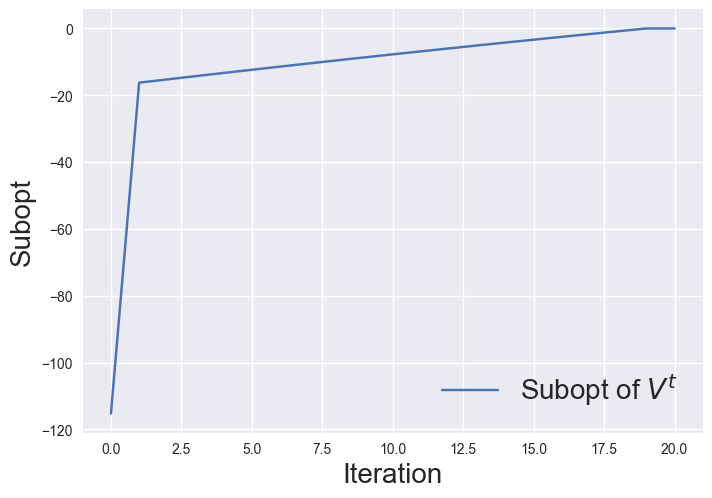

In [44]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

<span style="color: blue;"> **Answer:**</span>   
#### Proof.
For any **V'**, **V** ∈ ℝ\(|S|\) and $s \in S$, we have:

$$
\begin{aligned}
\left| (T V')(s) - (T V)(s) \right|
&= \max_{a \in A} \left[ r(s, a) + \gamma \sum_{s' \in S} P(s'|s, a) V'(s') \right] - \max_{a' \in A} \left[ r(s, a') + \gamma \sum_{s' \in S} P(s'|s, a') V(s') \right] \\

&\leq \max_{a \in A} \left( r(s, a) + \gamma \sum_{s' \in S} P(s'|s, a) V'(s') \right) - \left( r(s, a) + \gamma \sum_{s' \in S} P(s'|s, a) V(s') \right) \\

&\leq \max_{a \in A} \gamma \sum_{s' \in S} P(s'|s, a) \left| V'(s') - V(s') \right| \\

&\leq \| V' - V \|_{\infty} \max_{a \in A} \gamma \sum_{s' \in S} P(s'|s, a) = \gamma \| V' - V \|_{\infty}.
\end{aligned}
$$



The Value Iteration iterates can exceed $𝑉^⋆$ because each update is performed greedily over all states independently, effectively creating a “combined strategy” that is not practically realizable. As a result, the estimated values can temporarily overshoot any single policy’s true value. However, due to the contraction property of the Bellman optimality operator, these estimates eventually converge to the true optimal value function $𝑉^⋆$.


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_35048\2314215747.py:1: SyntaxWarning: invalid escape sequence '\p'
  plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)


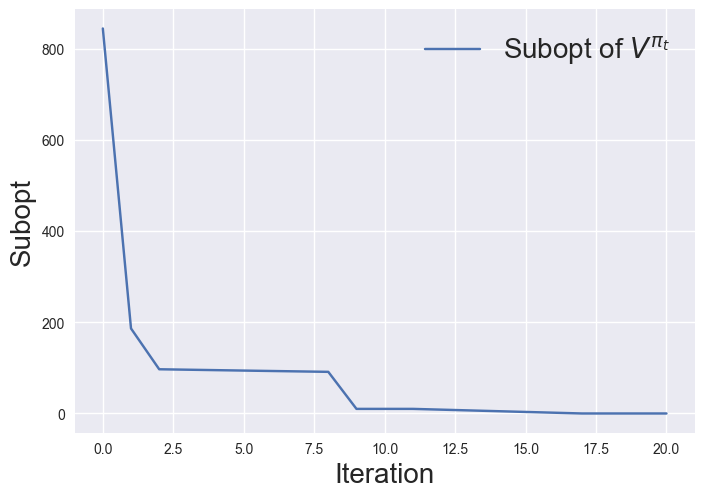

In [45]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

To better appreciate the difference in the convergence plot use log scale.

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_35048\126775526.py:2: SyntaxWarning: invalid escape sequence '\p'
  [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"],


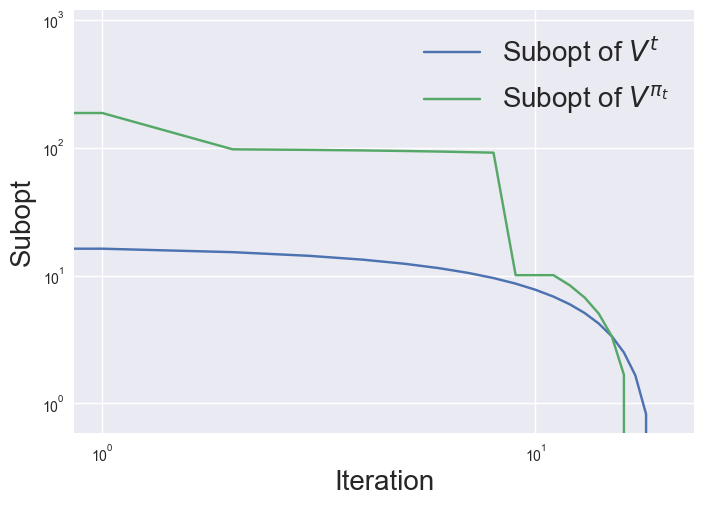

In [46]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# Ex 2: Policy Iteration [25 pts.]

In [47]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)   #0000ff
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]          #0000ff
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [48]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    # policy = []
    # for s in range(q.shape[0]):
    #     policy.append(???)
    # return policy

    policy = np.argmax(q, axis = 1) #0000FF
    return policy

In [49]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env, tol)  #0000FF
        pi   = get_greedy_policy(q)           #0000FF
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs, pi

In [77]:
start_time = time.time()  #00FF00
values_pi,_= policy_iteration(gridworld)
end_time = time.time()    #00FF00

print(end_time - start_time)

1.7296292781829834


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_35048\1006779507.py:1: SyntaxWarning: invalid escape sequence '\p'
  plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)


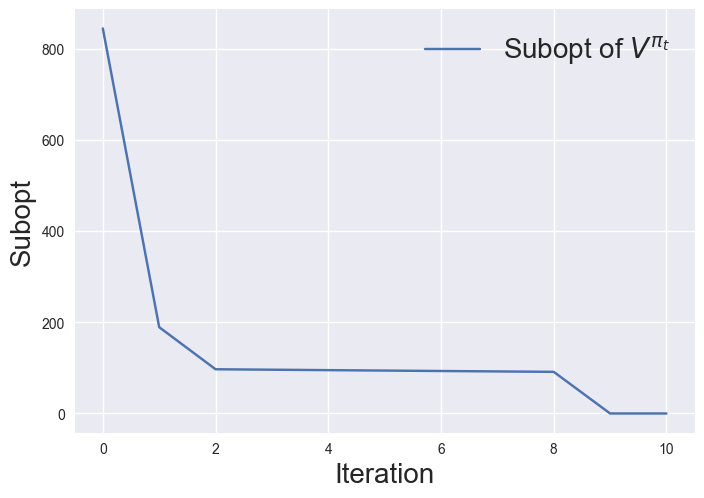

In [51]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

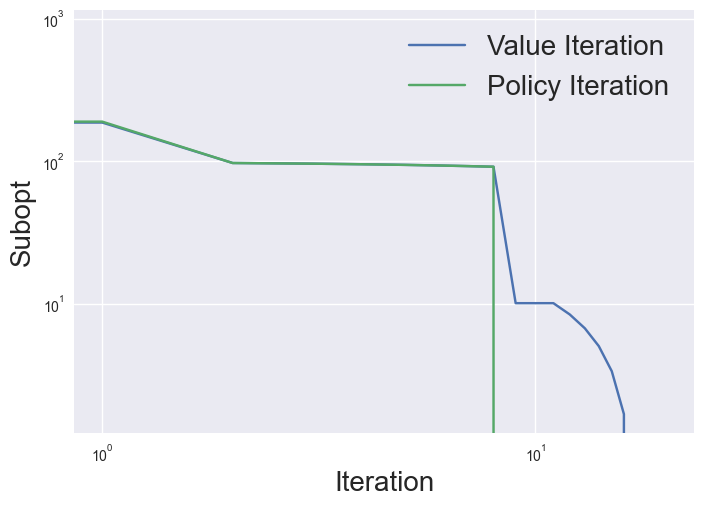

In [52]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

Question 1: The policy iteration algorithm converges faster  
Question 2:   <span style="color: red;"> **SHIT**</span>   
$T_{value.iteration} = O(\frac{\log(\epsilon(1-\gamma))}{\log(\gamma)}) = O(\frac{\log(10^{-10} \cdot 0.01)}{\log(0.99)}) = O(\frac{\log(10^{-12})}{\log(0.99)})$  
$T_{policy.iteration} = O(\frac{|S|(|A|-1)}{\gamma}) = O(\frac{100 \cdot 3}{0.01})$

***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

Question 1:  <span style="color: red;"> **SHIT**</span>   
  
  
Question 2:

> $
> \begin{aligned}
> T_\pi (V) - T_\pi (V') &= R_\pi + \gamma P_\pi V - ( R_\pi + \gamma P_\pi V') \\
>                        &= \gamma P_\pi V - \gamma P_\pi V' \\
>                        &= \gamma P_\pi (V-V')
> \end{aligned}
> $
> 
> Therefore, if $V>V'$, then $T_\pi (V) > T_\pi (V')$ since $P_\pi$ should be non-negative


# Ex 3: Modified Policy Iteration [25 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

* $m = \infty $ recovers policy iteration  
* $m = 1$ recovers value iteration 

First, write a function that applies the Bellman evaluation operator $m$ times

In [53]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m: #0000FF
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)  #0000FF   
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]      #0000FF
        i = i + 1 
    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [54]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        
        v, q = policy_operator_m_times(pi, m, env, v, q) #0000FF
        policies.append(np.argmax(q, axis = 1))          #0000FF     

        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [80]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

KeyboardInterrupt: 

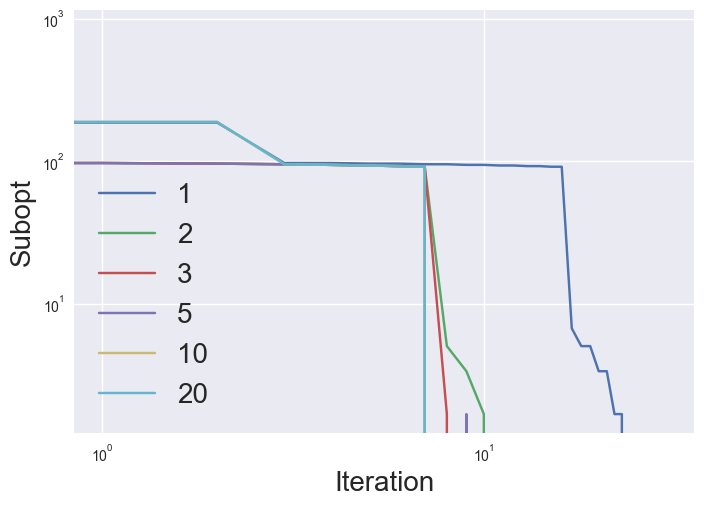

In [ ]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

Question 1: when m increase from 1 to 20, the iteration decreases.   
Question 2: $O(m \cdot (|A| |S|+|S|))$   <span style="color: red;"> **SHIT**</span>   

Question 3: $O(|S|^3+|S|^2 |A|)$

# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [57]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [58]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [59]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = Q[h, state, a] = (1 - alpha) * Q[h, state, a] + alpha * (rewards[-1] + V[h+1, new_state])  #0000FF

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [60]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [61]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = Q[h, state, a] = (1 - alpha)*Q[h, state, a] + alpha * (rewards[-1] + V[h+1, new_state])   #0000FF 

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [62]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

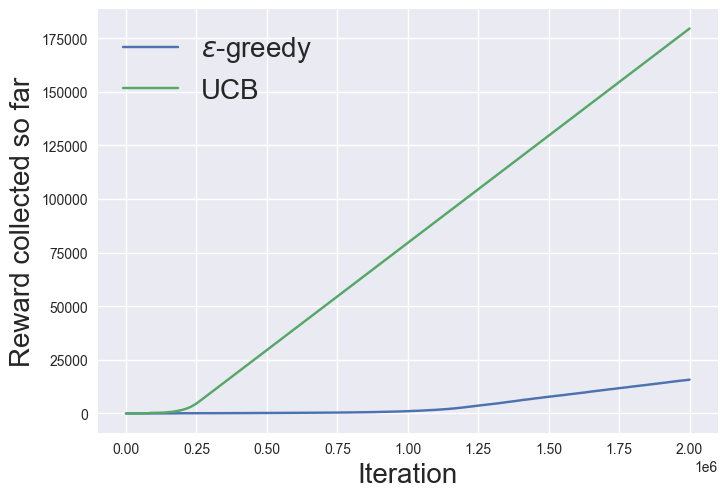

In [63]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False
)

问题: 你被给予了一个包含 $N$ 个状态的链式环境，即除了两个端点状态外，每个状态都有两种可能的动作：向右移动或返回到链中的第一个状态。对于端点状态，第二种动作是保持在相同的状态。只有当你处于最右端状态并且选择停留在那里时，奖励才为 1，否则奖励为 0。那么，在第一轮实验中，如果初始状态是链中最左端的状态，$\varepsilon$-贪心算法在 $H$ 步后获得正奖励的概率是多少？

问题: 这个经验结果是否与 (Jin et al. 2018) 论文中描述的理论结果相匹配？请阅读其附录 A，并查看他们在表 1 中针对 UCB-H 算法的描述后再回答此问题。

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

**Answer**: This is a Markov chain problem, and we can write the following equation to represent state transitions  
$$
\vec{s}' = 
\begin{bmatrix}
0.5 & 0.5 & 0 & 0 & 0 \\
0.5 & 0 & 0.5 & 0 & 0 \\
0 & 0.5 & \ddots & 0.5 & 0 \\
0 & 0 & 0.5 & 0 & 0.5 \\
0 & 0 & 0 & 0.5 & 0.5
\end{bmatrix}
\vec{s} = P_{N \times N} \vec s
$$

Obtaining a positive reward is equivalent to reaching node \(N\) from \(1\) at step \(i\), then staying at least once, and finally transitioning from node \(N\) to node \(K\), where \(K\) is any possible node in \(1\) to \(N\).  
Thus, the probability corresponding to this path is  
$$\text{Prob}=\sum_{i=1}^{N-1} P_{(1,N)}^i \cdot 0.5 \sum_{k=1}^{N} P_{(N,k)}^{H-i-1} = \sum_{i=1}^{N-1} P_{(1,N)}^i \cdot 0.5$$



**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

**Answer:** Yes, the result matches. Because we see the rewards collected by UCB is much larger than epsilon greedy when iteration increases. <span style="color: red;"> **SHIT**</span>     

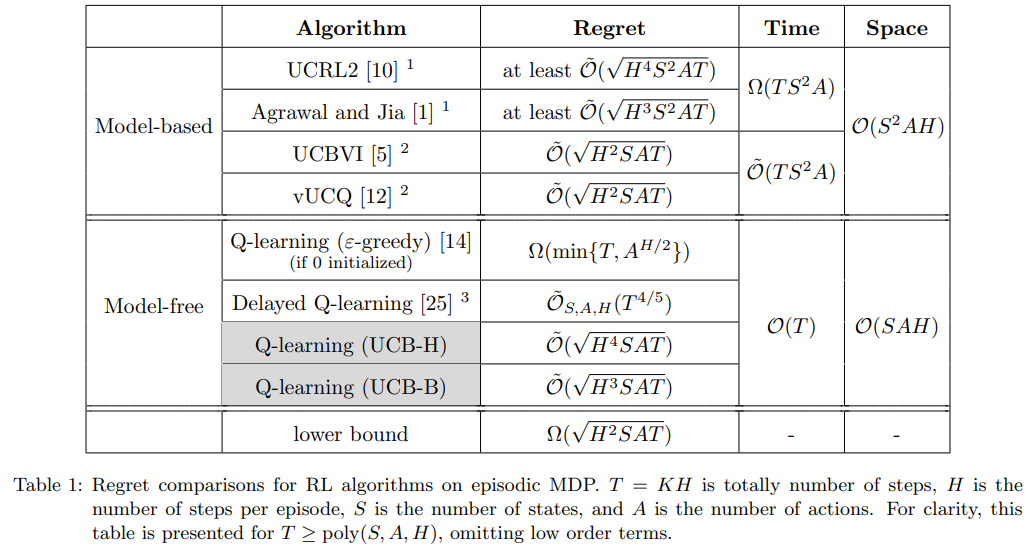

## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [64]:
def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]                     # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)           # Current value estimate
            theta -= alpha * phi_s * (V_hat - G)   # Gradient descent update #0000FF

    return theta


In [65]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        state = 99  # Initial state
        for _ in range(H):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target  = reward + gamma * V_s_next  # TD target #0000FF
            td_error   = V_s - td_target            # TD error  #0000FF

            # Update theta using gradient descent
            theta -= alpha * td_error * phi_s       #0000FF 
            #add α·(V_s - reward - γ·V_s_next)·φ_s

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [69]:
from tqdm import tqdm

_, pi=policy_iteration(gridworld)

K_MINE = 20

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=K_MINE, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=K_MINE, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 20/20 [00:00<00:00, 30.24it/s]

8.919948611419325e-07


**Case 2:**

In [70]:
_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50,:]*=0

K_MINE = 20

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=K_MINE, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=K_MINE, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 20/20 [00:00<00:00, 28.42it/s]

190.43020836185028


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

**Answers**


Question 1: MC DT have the same result

Question 2:  
>$$
>\begin{aligned}
>\Phi^\top \mathrm{diag}(\rho)\,\bigl(\Phi\,\theta^*_{MC} - V^\pi\bigr) &= 0 \\[6pt]
>I^\top \mathrm{diag}(\rho) (I \theta^*_{MC} - V^\pi) & = 0 \\[6pt]
>\mathrm{diag}(\rho) ( \theta^*_{MC} - V^\pi)&= 0 \\[6pt]
>\theta^*_{MC}
>&= V^\pi.
>\end{aligned}
>$$

>$$
>\begin{aligned}
>\theta^*_{TD} &= (\Phi^\top diag(\rho) \Phi)^{-1} \Phi^\top diag(\rho) T^\pi \Phi \theta^*_{TD} \\
>\theta^*_{TD} &= (I^\top diag(\rho) I)^{-1} I^\top diag(\rho) T^\pi I \theta^*_{TD} \\
>\theta^*_{TD} &= (diag(\rho))^{-1} diag(\rho) T^\pi \theta^*_{TD} \\
>\theta^*_{TD} &= T^\pi \theta^*_{TD} \\
>\theta^*_{TD} &= V^\pi
>\end{aligned}
>$$

Therefore, MC and TD are the same when $\Phi = I$.

**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.

**Question 1:** The results of the MC and TD algorithms are **inconsistent**.

**Question 2:**

Since the matrix $\Phi$ sets the first 0-49 rows to zero, according to the update formulas of MC and TD, no matter how the update is performed, the values of $\theta(s = 0\sim49)$ will always remain zero. Therefore, we do not need to consider the first 0-49 terms, which allows us to simplify the equations.

Based on the derivation above, we obtain the following equations. Note that $\hat{\theta}$ represents the vector containing only the elements of the original $\theta$ from indices 50 to 99.

> $$
> \hat{\theta}^*_{MC} = \hat{V}^\pi
> $$

> $$
> \begin{aligned}
> \hat{\theta}^*_{TD} &= (\hat{\Phi}^\top \operatorname{diag}(\rho) \hat{\Phi})^{-1} \hat{\Phi}^\top \operatorname{diag}(\rho) \hat{T}^\pi \hat{\Phi} \hat{\theta}^*_{TD} \\
> \hat{\theta}^*_{TD} &= (\hat{I}^\top \operatorname{diag}(\rho) \hat{I})^{-1} \hat{I}^\top \operatorname{diag}(\rho) \hat{T}^\pi \hat{I} \hat{\theta}^*_{TD} \\
> \hat{\theta}^*_{TD} &= (\operatorname{diag}(\rho))^{-1} \operatorname{diag}(\rho) T^\pi \hat{\theta}^*_{TD} \\
> \hat{\theta}^*_{TD} &= \hat{T}^\pi \hat{\theta}^*_{TD} \\
> \end{aligned}
> $$

Note the term $\hat{T}^\pi$. From the code, we observe that only when $s=0$ there is a reward of 1, while for all other states, the reward is 0. Therefore, the operator $\hat{T}^\pi V$ simplifies to:
> $$
> \hat{T}^\pi V := 0 + \gamma V
> $$

Thus, we obtain the following result:

> $$
> \hat{\theta}^*_{TD} = \vec{0} \\
> $$

As a result, the MC and TD solutions are not the same.

